Import required libraries



In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

Load the Dataset


In [17]:
df = pd.read_csv('/spam (3).csv',delimiter=',',encoding='latin-1')
 

In [18]:
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Data preprocessing


In [19]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [20]:
df.shape


(5572, 3)

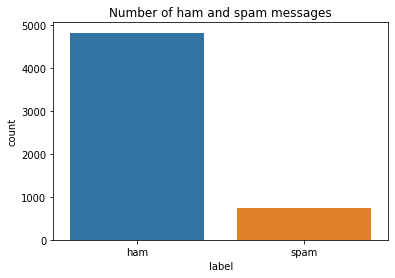

In [21]:
plt.title('Number of ham and spam messages')
sns.countplot(x=df['label'])
plt.show()

Train-test split


In [22]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split
  
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

Tokenizer


In [23]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = keras.utils.pad_sequences(sequences,maxlen=max_len)

Add Layers


In [24]:
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words,50,input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)

Create Model


In [25]:
model = Model(inputs=inputs,outputs=layer)


Compile the Model


In [26]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Fit the Model


In [34]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])


Epoch 1/10
28/28 [==============================] - 11s 294ms/step - loss: 0.3239 - accuracy: 0.8721 - val_loss: 0.1842 - val_accuracy: 0.9316
Epoch 2/10
28/28 [==============================] - 7s 266ms/step - loss: 0.0819 - accuracy: 0.9798 - val_loss: 0.0589 - val_accuracy: 0.9832


Save the Model


In [29]:
model.save('spam_lstm_model_1.h5')


Test the Model


In [30]:
#processing test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = keras.utils.pad_sequences(test_sequences,maxlen=max_len)

In [35]:
#evaluation of our model
accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 1s 23ms/step - loss: 0.0735 - accuracy: 0.9785
Test set
  Loss: 0.074
  Accuracy: 0.978
